# Import CSV Data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import json
import pprint

from datetime import datetime, timedelta
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional
from keras.layers.core import Dense, Dropout
from keras.optimizers import SGD, Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

prettyprint_config = pprint.PrettyPrinter(indent=4)
prettyprint = prettyprint_config.pprint

isGdrive = True

In [2]:
if isGdrive:
    # For Google Colab
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/gdrive', force_remount=True)
    df = pd.read_csv('/content/gdrive/My Drive/CS3237_Project/data.csv')
    graph_dir = '/content/gdrive/My Drive/CS3237_Project/graphs'

else:
    # For Local Runs
    df = pd.read_csv('data.csv')
    # Plotting - comment out if you don't want
    cur_dir = os.getcwd()
    new_dir = cur_dir + '/graphs'
    if not os.path.exists('graphs'):
        os.makedirs('graphs')

Mounted at /content/gdrive


In [3]:
#drop invalid shots
#df.score.unique()
#df.loc[(df['score'] != 1) & (df['score'] != 0)]
df = df.drop(df[(df['score'] != 1) & (df['score'] != 0)].index).reset_index(drop=True)

In [4]:
print(df.shape) # (totalNumberOfShots, metrics)
totalNumberOfShots = df.shape[0]
df.isnull().any()

(513, 5)


light            False
accelerometer    False
magnetometer     False
gyroscope        False
score            False
dtype: bool

In [5]:
df.head()

,light,accelerometer,magnetometer,gyroscope,score
0,"{""0"": [0.48, ""2020-10-25T09:07:15.173376""], ""1...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:07:15.015...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:07:15.021...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:07:15.016...",0
1,"{""0"": [775.04, ""2020-10-25T09:13:31.041089""], ...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:13:30.872...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:13:30.880...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:13:30.873...",1
2,"{""0"": [13.72, ""2020-10-25T09:14:19.713369""], ""...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:14:19.537...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:14:19.550...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:14:19.538...",1
3,"{""0"": [3.94, ""2020-10-25T09:14:32.101211""], ""1...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:14:31.927...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:14:31.933...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:14:31.928...",0
4,"{""0"": [4.83, ""2020-10-25T09:14:42.008443""], ""1...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:14:41.850...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:14:41.856...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T09:14:41.851...",0


In [6]:
df.tail()

,light,accelerometer,magnetometer,gyroscope,score
508,"{""0"": [0.08, ""2020-10-25T11:08:36.982468""], ""1...","{""0"": [0.111328125, 1.4345703125, 1.546875, ""2...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T11:08:36.744...","{""0"": [-10.223388671875, 41.74041748046875, 33...",0
509,"{""0"": [2.33, ""2020-10-25T11:08:45.268114""], ""1...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T11:08:44.720...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T11:08:44.726...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T11:08:44.721...",1
510,"{""0"": [5.15, ""2020-10-25T11:08:53.007532""], ""1...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T11:08:52.640...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T11:08:52.642...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T11:08:52.640...",1
511,"{""0"": [2.0100000000000002, ""2020-10-25T11:09:0...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T11:09:00.260...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T11:09:00.263...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T11:09:00.261...",0
512,"{""0"": [0.08, ""2020-10-25T11:10:44.061164""], ""1...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T11:10:43.879...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T11:10:43.883...","{""0"": [0.0, 0.0, 0.0, ""2020-10-25T11:10:43.879...",0


# Organize DataFrame into Arrays and Tuples

In [7]:
lightList = []
accelerometerList = []
gyroscopeList = []
score_master_list = [] # does not need further data organization

for shotIdx in range(totalNumberOfShots):
    lightList.append(json.loads(df.loc[shotIdx]['light']))
    accelerometerList.append(json.loads(df.loc[shotIdx]['accelerometer']))
    gyroscopeList.append(json.loads(df.loc[shotIdx]['gyroscope']))
    score_master_list.append(df.loc[shotIdx]['score'])

if (len(lightList)==len(accelerometerList)==len(gyroscopeList)==len(score_master_list)==totalNumberOfShots):
    print("Correct number of shots across all lists: %d" % totalNumberOfShots)
else:
    print("WARNING: CHECK CSV FILE!!!")

Correct number of shots across all lists: 513


In [8]:
light_master_list = []
accelerometer_master_list = []
gyroscope_master_list = []

for shotIdx in range(totalNumberOfShots):
    data_entries_list = ([(key, value) for key, value in lightList[shotIdx].items()]) # Stored as a tuple (#, [reading, timestamp])
    light_master_list.append(data_entries_list)

    data_entries_list = ([(key, value) for key, value in accelerometerList[shotIdx].items()]) # Stored as a tuple (#, [X,Y,Z, timestamp])
    accelerometer_master_list.append(data_entries_list)

    data_entries_list = ([(key, value) for key, value in gyroscopeList[shotIdx].items()]) # Stored as a tuple (#, [X,Y,Z, timestamp])
    gyroscope_master_list.append(data_entries_list)

# How to navigate the data

In [9]:
# Printing shot #0 (first shot), data point #14 that is recorded. Take note of the timestamps!
print("Light Reading: ", light_master_list[0][14])
print("Accelerometer Reading: ", accelerometer_master_list[0][14])
print("Gyroscope Reading: ", gyroscope_master_list[0][14])
print(score_master_list[0]) # does not have the extra data point parameter, because only 1 value per shot

Light Reading:  ('14', [1348.48, '2020-10-25T09:07:16.539657'])
Accelerometer Reading:  ('14', [-2.2578125, -0.00048828125, 3.3310546875, '2020-10-25T09:07:16.433804'])
Gyroscope Reading:  ('14', [61.553955078125, -110.015869140625, 54.92401123046875, '2020-10-25T09:07:16.435352'])
0


In [10]:
# To access tuple
print(light_master_list[0][14][1])

[1348.48, '2020-10-25T09:07:16.539657']


In [11]:
# To access data within tuple
print(light_master_list[0][14][1][1])

2020-10-25T09:07:16.539657


# Organize by Timestamps

In [12]:
TUPLE_DATA_POSITION = 1
LIGHT_DATA_POSITION = 0
LIGHT_TIMESTAMP_POSITION = 1
ACC_X_POSITION = 0
ACC_Y_POSITION = 1
ACC_Z_POSITION = 2
ACC_TIMESTAMP_POSITION = 3
GYRO_X_POSITION = 0
GYRO_Y_POSITION = 1
GYRO_Z_POSITION = 2
GYRO_TIMESTAMP_POSITION = 3

light_per_shot_arr = []
acc_per_shot_arr = []
gyro_per_shot_arr = []

for shotIdx in range(totalNumberOfShots):
    light_timestamp_dict = {'timestamp': [], 'reading': []}
    accelerometer_timestamp_dict = {'timestamp': [], 'X': [], 'Y': [], 'Z': []}
    gyroscope_timestamp_dict = {'timestamp': [], 'X': [], 'Y': [], 'Z': []}

    # LIGHT
    for dataPointIdx in range(len(light_master_list[shotIdx])):
        light_timestamp_dict['timestamp'].append(light_master_list[shotIdx][dataPointIdx][TUPLE_DATA_POSITION][LIGHT_TIMESTAMP_POSITION])
        light_timestamp_dict['reading'].append(light_master_list[shotIdx][dataPointIdx][TUPLE_DATA_POSITION][LIGHT_DATA_POSITION])
    light_per_shot_arr.append(light_timestamp_dict)

    # ACC
    for dataPointIdx in range(len(accelerometer_master_list[shotIdx])):
        accelerometer_timestamp_dict['timestamp'].append(accelerometer_master_list[shotIdx][dataPointIdx][TUPLE_DATA_POSITION][ACC_TIMESTAMP_POSITION])
        accelerometer_timestamp_dict['X'].append(accelerometer_master_list[shotIdx][dataPointIdx][TUPLE_DATA_POSITION][ACC_X_POSITION])
        accelerometer_timestamp_dict['Y'].append(accelerometer_master_list[shotIdx][dataPointIdx][TUPLE_DATA_POSITION][ACC_Y_POSITION])
        accelerometer_timestamp_dict['Z'].append(accelerometer_master_list[shotIdx][dataPointIdx][TUPLE_DATA_POSITION][ACC_Z_POSITION])
    acc_per_shot_arr.append(accelerometer_timestamp_dict)
    
    # GYRO
    for dataPointIdx in range(len(gyroscope_master_list[shotIdx])):
        gyroscope_timestamp_dict['timestamp'].append(gyroscope_master_list[shotIdx][dataPointIdx][TUPLE_DATA_POSITION][GYRO_TIMESTAMP_POSITION])
        gyroscope_timestamp_dict['X'].append(gyroscope_master_list[shotIdx][dataPointIdx][TUPLE_DATA_POSITION][GYRO_X_POSITION])
        gyroscope_timestamp_dict['Y'].append(gyroscope_master_list[shotIdx][dataPointIdx][TUPLE_DATA_POSITION][GYRO_Y_POSITION])
        gyroscope_timestamp_dict['Z'].append(gyroscope_master_list[shotIdx][dataPointIdx][TUPLE_DATA_POSITION][GYRO_Z_POSITION])
    gyro_per_shot_arr.append(gyroscope_timestamp_dict)

(Optional)

In [13]:
# Need to convert timestamp 'str' to datetime64[ns] # ACTUALLY DONT NEED ALSO CAN
#for shotIdx in range(totalNumberOfShots):
#    df_light = pd.DataFrame(light_per_shot_arr[shotIdx])
#    df_light['timestamp'] = df_light['timestamp'].astype('datetime64[ns]')
#    light_per_shot_arr[shotIdx] = df_light.to_dict()
    #print(df_light.dtypes)

In [14]:
# Example shot #0
df_light = pd.DataFrame(light_per_shot_arr[0])
df_light

,timestamp,reading
0,2020-10-25T09:07:15.173376,0.48
1,2020-10-25T09:07:15.277420,0.33
2,2020-10-25T09:07:15.331647,0.08
3,2020-10-25T09:07:15.447321,0.40
4,2020-10-25T09:07:15.553743,0.64
5,2020-10-25T09:07:15.645685,0.88
6,2020-10-25T09:07:15.764385,0.96
7,2020-10-25T09:07:15.868304,1.04
8,2020-10-25T09:07:15.962377,0.88
9,2020-10-25T09:07:16.066338,0.08


# Plot Time-Series Graphs

## LIGHT

No handles with labels found to put in legend.


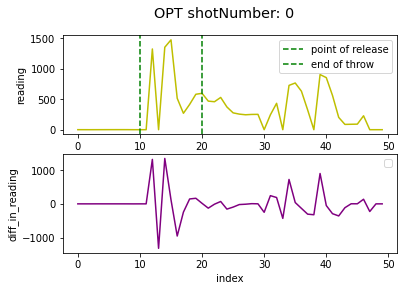

In [15]:
choose_shot_to_plot = 0
start_idx = 10 # Based on visual inspection
end_idx = 20 # Based on visual inspection

# Copy shot data for plot
shot = pd.DataFrame.from_dict(light_per_shot_arr[choose_shot_to_plot])
shot.set_index('timestamp', inplace=True)
shot['difference'] = shot['reading'].diff()
shot['difference'].fillna(0.0, inplace = True) # for the edge cases where the subtraction will give NA

data_temp = {'timestamp':light_per_shot_arr[choose_shot_to_plot]['timestamp'], 
             'reading':light_per_shot_arr[choose_shot_to_plot]['reading'], 
             'diff_in_reading':shot['difference'],
             'index':list(range(0,shot['reading'].size))}
graph = DataFrame(data_temp,columns=['timestamp','reading','diff_in_reading','index'])

# Marks out the point of release
start_idx = graph['index'][start_idx]
end_idx = graph['index'][end_idx] # Based on visual inspection

# Plots lines
plt.suptitle("OPT shotNumber: {}".format(choose_shot_to_plot), fontsize="x-large")
plt.subplot(211)
plt.plot(graph['index'], graph['reading'], "y")
plt.ylabel("reading")
plt.axvline(x=start_idx, linestyle='--',label='point of release',color= 'green')
plt.axvline(x=end_idx, linestyle='--',label='end of throw',color = 'green')
plt.legend()
plt.subplot(212)
plt.plot(graph['index'], graph['diff_in_reading'], "purple")
plt.ylabel("diff_in_reading")
plt.xlabel("index")
plt.legend()

# Graph saving
graph_name = "OPT_shotNumber_{}".format(choose_shot_to_plot) + '.png'
plt.savefig(f"{graph_dir}/opt/{graph_name}")

## ACCELEROMETER [X, Y, Z print separately]

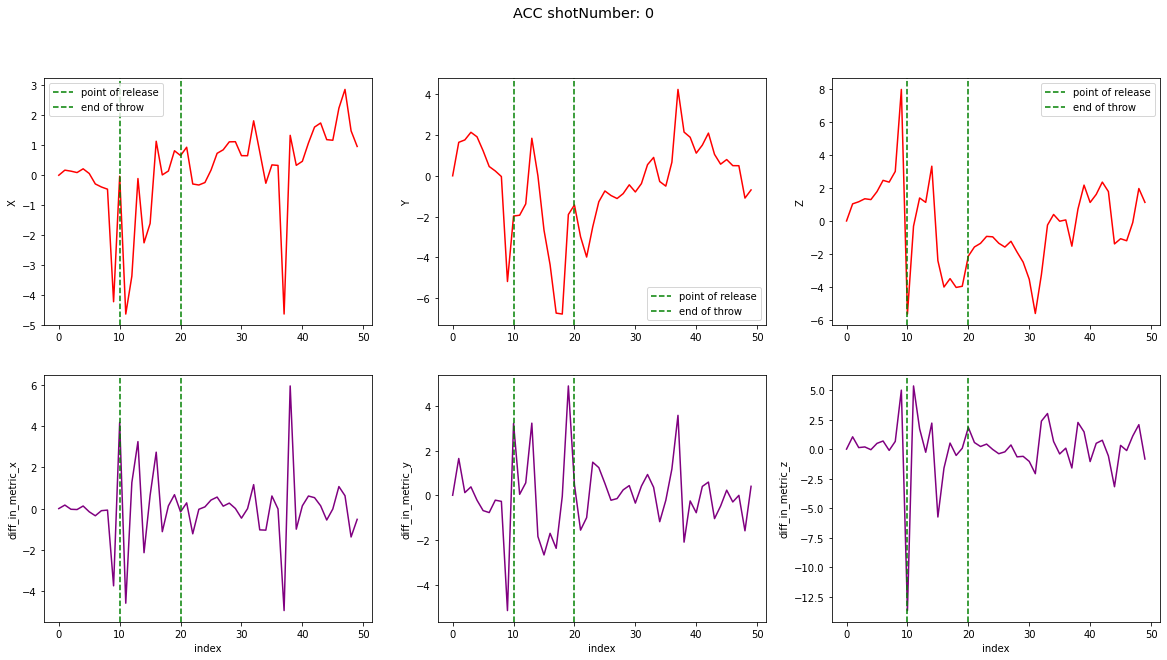

In [16]:
choose_shot_to_plot = 0
choose_metric_x = 'X'
choose_metric_y = 'Y'
choose_metric_z = 'Z'

# Copy shot data for plot
shot = pd.DataFrame.from_dict(acc_per_shot_arr[choose_shot_to_plot])
shot.set_index('timestamp', inplace=True)
shot['difference_x'] = shot[choose_metric_x].diff()
shot['difference_x'].fillna(0.0, inplace = True) # for the edge cases where the subtraction will give NA
shot['difference_y'] = shot[choose_metric_y].diff()
shot['difference_y'].fillna(0.0, inplace = True) # for the edge cases where the subtraction will give NA
shot['difference_z'] = shot[choose_metric_z].diff()
shot['difference_z'].fillna(0.0, inplace = True) # for the edge cases where the subtraction will give NA

data_temp = {'timestamp':acc_per_shot_arr[choose_shot_to_plot]['timestamp'], 
             choose_metric_x:acc_per_shot_arr[choose_shot_to_plot][choose_metric_x], 
             'diff_in_metric_x':shot['difference_x'],
             choose_metric_y:acc_per_shot_arr[choose_shot_to_plot][choose_metric_y], 
             'diff_in_metric_y':shot['difference_y'],
             choose_metric_z:acc_per_shot_arr[choose_shot_to_plot][choose_metric_z], 
             'diff_in_metric_z':shot['difference_z'],
             'index':list(range(0,shot[choose_metric_x].size))}
graph = DataFrame(data_temp,columns=['timestamp',
                                     choose_metric_x,'diff_in_metric_x',
                                     choose_metric_y,'diff_in_metric_y',
                                     choose_metric_z,'diff_in_metric_z',
                                     'index'])

# Marks out the point of release
start_idx = graph['index'][start_idx]
end_idx = graph['index'][end_idx] # Based on visual inspection

plt.figure(figsize=(20,10))

# Plot function
def plot_metric(choose_metric, diff_in_metric, pos1, pos2):
    plt.subplot(pos1)
    plt.plot(graph['index'], graph[choose_metric], "r")
    plt.ylabel(choose_metric)
    plt.axvline(x=start_idx, linestyle='--',label='point of release',color= 'green')
    plt.axvline(x=end_idx, linestyle='--',label='end of throw',color = 'green')
    plt.legend()
    plt.subplot(pos2)
    plt.plot(graph['index'], graph[diff_in_metric], "purple")
    plt.ylabel(diff_in_metric)
    plt.axvline(x=start_idx, linestyle='--',label='point of release',color= 'green')
    plt.axvline(x=end_idx, linestyle='--',label='end of throw',color = 'green')
    plt.xlabel("index")

# Plot 6 graphs
plt.suptitle("ACC shotNumber: {}".format(choose_shot_to_plot), fontsize="x-large")
plot_metric(choose_metric_x, "diff_in_metric_x", 231, 234)
plot_metric(choose_metric_y, "diff_in_metric_y", 232, 235)
plot_metric(choose_metric_z, "diff_in_metric_z", 233, 236)

# Graph saving
graph_name = "ACC_shotNumber_{}".format(choose_shot_to_plot) + '.png'
plt.savefig(f"{graph_dir}/acc/{graph_name}")

## GYROSCOPE [X, Y, Z print separately]

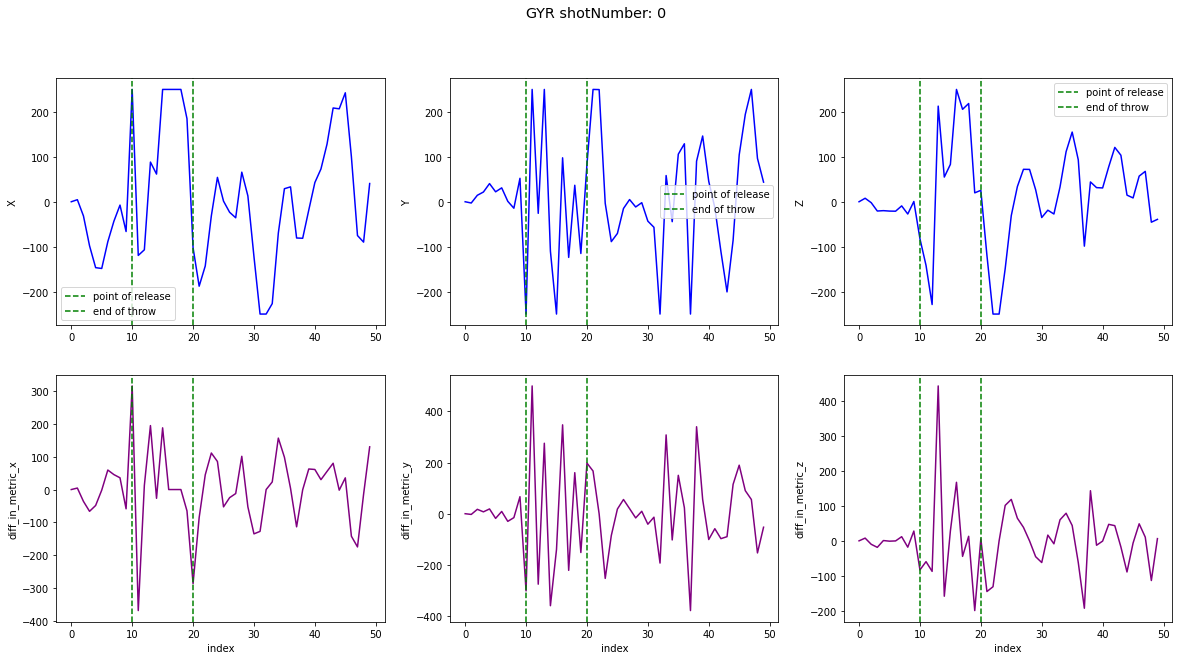

In [17]:
choose_shot_to_plot = 0
choose_metric_x = 'X'
choose_metric_y = 'Y'
choose_metric_z = 'Z'

# Copy shot data for plot
shot = pd.DataFrame.from_dict(gyro_per_shot_arr[choose_shot_to_plot])
shot.set_index('timestamp', inplace=True)
shot['difference_x'] = shot[choose_metric_x].diff()
shot['difference_x'].fillna(0.0, inplace = True) # for the edge cases where the subtraction will give NA
shot['difference_y'] = shot[choose_metric_y].diff()
shot['difference_y'].fillna(0.0, inplace = True) # for the edge cases where the subtraction will give NA
shot['difference_z'] = shot[choose_metric_z].diff()
shot['difference_z'].fillna(0.0, inplace = True) # for the edge cases where the subtraction will give NA

data_temp = {'timestamp':gyro_per_shot_arr[choose_shot_to_plot]['timestamp'], 
             choose_metric_x:gyro_per_shot_arr[choose_shot_to_plot][choose_metric_x], 
             'diff_in_metric_x':shot['difference_x'],
             choose_metric_y:gyro_per_shot_arr[choose_shot_to_plot][choose_metric_y], 
             'diff_in_metric_y':shot['difference_y'],
             choose_metric_z:gyro_per_shot_arr[choose_shot_to_plot][choose_metric_z], 
             'diff_in_metric_z':shot['difference_z'],
             'index':list(range(0,shot[choose_metric_x].size))}
graph = DataFrame(data_temp,columns=['timestamp',
                                     choose_metric_x,'diff_in_metric_x',
                                     choose_metric_y,'diff_in_metric_y',
                                     choose_metric_z,'diff_in_metric_z',
                                     'index'])

# Marks out the point of release
start_idx = graph['index'][start_idx]
end_idx = graph['index'][end_idx] # Based on visual inspection

plt.figure(figsize=(20,10))

# Plot function
def plot_metric(choose_metric, diff_in_metric, pos1, pos2):
    plt.subplot(pos1)
    plt.plot(graph['index'], graph[choose_metric], "blue")
    plt.ylabel(choose_metric)
    plt.axvline(x=start_idx, linestyle='--',label='point of release',color= 'green')
    plt.axvline(x=end_idx, linestyle='--',label='end of throw',color = 'green')
    plt.legend()
    plt.subplot(pos2)
    plt.plot(graph['index'], graph[diff_in_metric], "purple")
    plt.ylabel(diff_in_metric)
    plt.axvline(x=start_idx, linestyle='--',label='point of release',color= 'green')
    plt.axvline(x=end_idx, linestyle='--',label='end of throw',color = 'green')
    plt.xlabel("index")

# Plot 6 graphs
plt.suptitle("GYR shotNumber: {}".format(choose_shot_to_plot), fontsize="x-large")
plot_metric(choose_metric_x, "diff_in_metric_x", 231, 234)
plot_metric(choose_metric_y, "diff_in_metric_y", 232, 235)
plot_metric(choose_metric_z, "diff_in_metric_z", 233, 236)

# Graph saving
graph_name = "GYR_shotNumber_{}".format(choose_shot_to_plot) + '.png'
plt.savefig(f"{graph_dir}/gyr/{graph_name}")

# ML LSTM

## reshape data for ML

In [18]:
LIGHT_THRESHOLD = 400

# Calculate the index to truncate after in a timestamp sorted dataframe
def calculate_truncate_index(sorted_sample_light_df, shot_number):
  num_indexes = sorted_sample_light_df.shape[0]
  for i in range(int(num_indexes)):
    if sorted_sample_light_df.at[i, 'light'] > LIGHT_THRESHOLD:
      return i

  raise Exception(f"Light readings for shot number {shot_number} never exceeded threshold!")


def pad_data(df, list):
  padded_df = pd.DataFrame()
  #truncate data or pad data depending on the length of data
  if df.shape[0] > 10:
    truncated_df = df.iloc[df.shape[0]-10:df.shape[0]]
    return truncated_df.reset_index(drop=True)
  else:
    rows_to_add = 10 - df.shape[0]
    for rows in range(rows_to_add):
      padded_df = padded_df.append(list, ignore_index=True)
  #while padded_df.shape[0] < 15:
  #  padded_df = padded_df.append(list, ignore_index=True)
  #  padded_df.iloc[0] = list
  return padded_df.append(df, ignore_index=True)

#Merged data of shotNumber  in to 1 sample dataframe
def get_sample_df(shotNumber):
    sample_light_df = pd.DataFrame(light_per_shot_arr[shotNumber]).sort_values(["timestamp"],kind='mergesort', ignore_index=True).drop(columns=["timestamp"]).rename(columns={"reading" : "light"})
    truncate_index = calculate_truncate_index(sample_light_df, shotNumber)
    sample_light_df = sample_light_df.truncate(after=truncate_index)
    
    sample_acc_df = pd.DataFrame(acc_per_shot_arr[shotNumber]).sort_values(["timestamp"],kind='mergesort',ignore_index=True).truncate(after=truncate_index).drop(columns=["timestamp"]).rename(columns={"X": "accel_X", "Y": "accel_Y", "Z": "accel_Z"})
    sample_acc_df = pad_data(sample_acc_df,{'accel_X': 0, 'accel_Y':0, 'accel_Z': 0})

    sample_gyro_df = pd.DataFrame(gyro_per_shot_arr[shotNumber]).sort_values(["timestamp"],kind='mergesort', ignore_index=True).truncate(after=truncate_index).drop(columns=["timestamp"]).rename(columns={"X": "gyro_X", "Y": "gyro_Y", "Z": "gyro_Z"})
    sample_gyro_df = pad_data(sample_gyro_df,{'gyro_X': 0, 'gyro_Y':0, 'gyro_Z': 0})

    sample_df = pd.merge(sample_acc_df, sample_gyro_df,left_index=True, right_index=True) # Without light readings
    return sample_df, truncate_index

get_sample_df(20)


(    accel_X   accel_Y   accel_Z      gyro_X      gyro_Y      gyro_Z
 0  0.000000  0.000000  0.000000    0.000000    0.000000    0.000000
 1  0.000000  0.000000  0.000000    0.000000    0.000000    0.000000
 2 -0.404297  0.565430  1.815918  -43.045044   -1.998901   -0.381470
 3 -0.194824  0.110840  1.761230  -47.981262  -20.263672  -22.430420
 4 -0.223145 -0.013184  1.878906  -45.661926   11.367798  -16.082764
 5 -0.726074 -0.267578  2.642578  -28.930664   12.947083    4.554749
 6 -1.830078 -1.793457  7.233398   -6.332397  -25.497437  -18.745422
 7 -2.274414  0.952637  4.495117  249.992371 -247.848511  -22.666931
 8  7.351562  6.884766  4.537109 -250.000000  249.992371 -250.000000
 9 -7.890137 -0.776367  2.427246  -31.005859   42.114258 -250.000000, 8)

In [19]:
def calculate_abs_accel_at_index(sample_df, index):
  return abs(sample_df.at[index, 'accel_X']) + abs(sample_df.at[index, 'accel_Y'])+ abs(sample_df.at[index, 'accel_Z'])

#store df of each shot into dict
truncate_index_accumulator = 0
abs_accel_accumulator = 0
abnormal_readings = []
sample_df_dict = {}
for shot_count in range(totalNumberOfShots):
    sample_df, truncate_index = get_sample_df(shot_count)
    if truncate_index > 9:
      truncate_index = 9
    truncate_index_accumulator += truncate_index
    abs_accel_at_cutoff = calculate_abs_accel_at_index(sample_df, 9)
    abs_accel_accumulator += abs_accel_at_cutoff
    # print(f"Throw Number: {shot_count+1} , Truncate Index: {truncate_index}") # For debugging...
    if  abs_accel_at_cutoff < 1:
      abnormal_readings.append({'throw_num': shot_count, 'truncate_index': truncate_index, 'abs_accel': abs_accel_at_cutoff})
    sample_df_dict[shot_count] = sample_df

print("Average truncate index: ", truncate_index_accumulator/(totalNumberOfShots))
print("Average accel at truncate index: ", abs_accel_accumulator/(totalNumberOfShots))
print("Abnormal Readings: ")
prettyprint(abnormal_readings)

Average truncate index:  6.662768031189084
Average accel at truncate index:  11.672231454830653
Abnormal Readings: 
[   {'abs_accel': 0.0, 'throw_num': 1, 'truncate_index': 0},
    {'abs_accel': 0.0, 'throw_num': 127, 'truncate_index': 0},
    {'abs_accel': 0.0, 'throw_num': 192, 'truncate_index': 0},
    {'abs_accel': 0.0, 'throw_num': 200, 'truncate_index': 0},
    {'abs_accel': 0.0, 'throw_num': 233, 'truncate_index': 0},
    {'abs_accel': 0.0, 'throw_num': 235, 'truncate_index': 0},
    {'abs_accel': 0.0, 'throw_num': 236, 'truncate_index': 0},
    {'abs_accel': 0.0, 'throw_num': 476, 'truncate_index': 0}]


In [20]:
#drop abnormal data
for throw_number in abnormal_readings:
  print(throw_number['throw_num'])
  sample_df_dict.pop(throw_number['throw_num'])
  #delete from score master list as well
  del score_master_list[throw_number['throw_num']]

1
127
192
200
233
235
236
476


In [21]:
print(len(sample_df_dict))

505


In [22]:
print(sample_df_dict[0])

    accel_X   accel_Y   accel_Z      gyro_X      gyro_Y      gyro_Z
0  0.089844  2.138672  1.350098  -98.045349   21.667480  -20.660400
1  0.214844  1.916504  1.299316 -146.697998   40.367126  -19.828796
2  0.059082  1.230957  1.783691 -148.529053   22.117615  -20.790100
3 -0.290527  0.456543  2.469727  -88.966370   30.914307  -21.057129
4 -0.392090  0.237305  2.361328  -43.334961    0.946045   -9.254456
5 -0.465820 -0.035645  3.011719   -7.461548  -14.381409  -27.313232
6 -4.225586 -5.194336  7.999756  -66.299438   52.177429    0.579834
7 -0.031738 -1.978516 -5.663086  249.992371 -250.000000  -82.359314
8 -4.637695 -1.936523 -0.318359 -119.461060  249.992371 -141.700745
9 -3.370117 -1.380859  1.397949 -106.971741  -25.794983 -228.767395


In [23]:
print(len(score_master_list))

505


In [24]:
#combine dict_df to a single df
samples_input_df = pd.DataFrame()
for key in sample_df_dict:
  samples_input_df = samples_input_df.append(sample_df_dict[key])

In [25]:
print(samples_input_df)

     accel_X   accel_Y   accel_Z      gyro_X     gyro_Y     gyro_Z
0   0.089844  2.138672  1.350098  -98.045349  21.667480 -20.660400
1   0.214844  1.916504  1.299316 -146.697998  40.367126 -19.828796
2   0.059082  1.230957  1.783691 -148.529053  22.117615 -20.790100
3  -0.290527  0.456543  2.469727  -88.966370  30.914307 -21.057129
4  -0.392090  0.237305  2.361328  -43.334961   0.946045  -9.254456
..       ...       ...       ...         ...        ...        ...
5   0.000000  0.000000  0.000000    0.000000   0.000000   0.000000
6  -0.621094  1.304199  1.499023  -93.330383  43.167114  19.012451
7  -0.018555  1.802734  1.945312 -145.797729   2.723694  29.472351
8  -0.265625  0.546875  2.646973 -108.406067   9.132385 -24.398804
9  -1.636719 -0.760254  5.383301  -45.433044  11.573792 -57.502747

[5050 rows x 6 columns]


In [26]:
#create scaler for each feature
scale_by_minmax = False
if scale_by_minmax:
  scaler_accX = MinMaxScaler(feature_range=(0,1)).fit(samples_input_df[['accel_X']])
  scaler_accY = MinMaxScaler(feature_range=(0,1)).fit(samples_input_df[['accel_Y']])
  scaler_accZ = MinMaxScaler(feature_range=(0,1)).fit(samples_input_df[['accel_Z']])
  scaler_gyroX = MinMaxScaler(feature_range=(0,1)).fit(samples_input_df[['gyro_X']])
  scaler_gyroY = MinMaxScaler(feature_range=(0,1)).fit(samples_input_df[['gyro_Y']])
  scaler_gyroZ = MinMaxScaler(feature_range=(0,1)).fit(samples_input_df[['gyro_Z']])
else:
  scaler_accX = StandardScaler().fit(samples_input_df[['accel_X']])
  scaler_accY = StandardScaler().fit(samples_input_df[['accel_Y']])
  scaler_accZ = StandardScaler().fit(samples_input_df[['accel_Z']])
  scaler_gyroX = StandardScaler().fit(samples_input_df[['gyro_X']])
  scaler_gyroY = StandardScaler().fit(samples_input_df[['gyro_Y']])
  scaler_gyroZ = StandardScaler().fit(samples_input_df[['gyro_Z']])

In [27]:
#transform data with scaler
norm_samples_input_df = samples_input_df
norm_samples_input_df['accel_X'] = scaler_accX.transform(samples_input_df[['accel_X']])
norm_samples_input_df['accel_Y'] = scaler_accY.transform(samples_input_df[['accel_Y']])
norm_samples_input_df['accel_Z'] = scaler_accZ.transform(samples_input_df[['accel_Z']])
norm_samples_input_df['gyro_X'] = scaler_gyroX.transform(samples_input_df[['gyro_X']])
norm_samples_input_df['gyro_Y'] = scaler_gyroY.transform(samples_input_df[['gyro_Y']])
norm_samples_input_df['gyro_Z'] = scaler_gyroZ.transform(samples_input_df[['gyro_Z']])

In [28]:
#sanity check
print(norm_samples_input_df)

     accel_X   accel_Y   accel_Z    gyro_X    gyro_Y    gyro_Z
0   0.275392  0.943584  0.054470 -0.811642  0.343976 -0.182728
1   0.333119  0.849553  0.038046 -1.252354  0.545915 -0.171298
2   0.261185  0.559400  0.194704 -1.268940  0.348837 -0.184511
3   0.099729  0.231634  0.416584 -0.729401  0.443833 -0.188182
4   0.052825  0.138843  0.381526 -0.316056  0.120203 -0.025948
..       ...       ...       ...       ...       ...       ...
5   0.233900  0.038406 -0.382184  0.076486  0.109986  0.101259
6  -0.052933  0.590399  0.102636 -0.768932  0.576153  0.362594
7   0.225331  0.801401  0.246976 -1.244199  0.139400  0.506371
8   0.111229  0.269867  0.473910 -0.905493  0.208608 -0.234114
9  -0.521969 -0.283367  1.358904 -0.335062  0.234973 -0.689144

[5050 rows x 6 columns]


In [29]:
#convert to numpy array
norm_samples_input_array = norm_samples_input_df.to_numpy()
print(norm_samples_input_array)
norm_samples_input_array.shape

[[ 0.27539184  0.94358439  0.05446954 -0.81164176  0.34397566 -0.18272831]
 [ 0.33311929  0.84955326  0.03804566 -1.25235401  0.54591518 -0.17129751]
 [ 0.26118547  0.55940004  0.19470417 -1.26894033  0.34883671 -0.1845111 ]
 ...
 [ 0.22533131  0.80140105  0.24697632 -1.24419907  0.13939964  0.50637081]
 [ 0.11122939  0.26986682  0.47391007 -0.90549266  0.2086078  -0.23411449]
 [-0.52196862 -0.28336691  1.35890431 -0.33506159  0.23497281 -0.68914433]]


(5050, 6)

In [30]:
#reshape samples array
#TODO normalize/scale data
samples_size = len(sample_df_dict)  #number of shots
timestamp_size = 10   #based on truncate value 
features = 6         #7 features(light, accelXYZ, gyroXYZ) should be 6 features when we truncate with light sensor

X = norm_samples_input_array.reshape(samples_size,timestamp_size,features)
X.shape
print(X[0])

[[ 0.27539184  0.94358439  0.05446954 -0.81164176  0.34397566 -0.18272831]
 [ 0.33311929  0.84955326  0.03804566 -1.25235401  0.54591518 -0.17129751]
 [ 0.26118547  0.55940004  0.19470417 -1.26894033  0.34883671 -0.1845111 ]
 [ 0.099729    0.23163438  0.41658442 -0.72940127  0.44383314 -0.18818154]
 [ 0.05282544  0.13884322  0.38152576 -0.31605644  0.12020261 -0.02594804]
 [ 0.01877527  0.02331925  0.59187772  0.00889715 -0.04532023 -0.27417473]
 [-1.71755832 -2.16006301  2.20512873 -0.52407649  0.67345592  0.10922907]
 [ 0.21924287 -0.79898818 -2.21376249  2.34100237 -2.58979113 -1.03080997]
 [-1.90787852 -0.78121526 -0.48514954 -1.00563255  2.80968108 -1.84648687]
 [-1.32248605 -0.5460341   0.06994589 -0.89250005 -0.16857667 -3.04326044]]


In [31]:
#target array of scores (hit or miss)
y = np.array(score_master_list[:samples_size])
y.shape

(505,)

In [32]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Optimizers


In [33]:
sgd_optimizer = SGD(learning_rate=0.01, momentum=0.1, nesterov=True, name="SGD")
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
loss = 'binary_crossentropy'
metrics = 'accuracy'

## Simple LSTM

In [34]:
#simple many to one LSTM
model_simple = Sequential()
model_simple.add(LSTM(50, activation='relu', input_shape=(timestamp_size, features)))  #using None for timestamp_size allows input with variable timestep length, but in one batchsize, length of timestep in each sample must be equal
model_simple.add(Dense(1))
model_simple.compile(optimizer=adam, loss=loss, metrics=metrics)

In [35]:
history_simple = model_simple.fit(X_train, y_train, epochs=200, verbose=1, batch_size=16, validation_split = 0.33)

Epoch 1/200
17/17 [==============================] - 0s 21ms/step - loss: 1.8295 - accuracy: 0.6963 - val_loss: 0.8097 - val_accuracy: 0.7015
Epoch 2/200
17/17 [==============================] - 0s 7ms/step - loss: 0.7582 - accuracy: 0.6444 - val_loss: 0.6492 - val_accuracy: 0.6791
Epoch 3/200
17/17 [==============================] - 0s 6ms/step - loss: 0.6845 - accuracy: 0.6333 - val_loss: 0.6411 - val_accuracy: 0.6791
Epoch 4/200
17/17 [==============================] - 0s 6ms/step - loss: 0.6670 - accuracy: 0.6444 - val_loss: 0.6355 - val_accuracy: 0.6866
Epoch 5/200
17/17 [==============================] - 0s 6ms/step - loss: 0.6530 - accuracy: 0.6704 - val_loss: 0.6339 - val_accuracy: 0.6866
Epoch 6/200
17/17 [==============================] - 0s 6ms/step - loss: 0.6400 - accuracy: 0.6926 - val_loss: 0.6318 - val_accuracy: 0.7015
Epoch 7/200
17/17 [==============================] - 0s 6ms/step - loss: 0.6286 - accuracy: 0.6926 - val_loss: 0.6273 - val_accuracy: 0.7015
Epoch 8/200


In [36]:
# Final evaluation of the model
scores = model_simple.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
lstm_model_accuracy = scores[1]*100

Accuracy: 67.33%


## Stacked LSTM

In [37]:
#Stacked many to one LSTM
model_stacked = Sequential()
model_stacked.add(LSTM(60, activation='tanh', return_sequences=True, input_shape=(timestamp_size, features)))
model_stacked.add(Dropout(0.2))
model_stacked.add(LSTM(40, activation='tanh', return_sequences=True))
model_stacked.add(Dropout(0.2))
model_stacked.add(LSTM(30, activation='tanh', return_sequences=True))
model_stacked.add(Dropout(0.2))
model_stacked.add(LSTM(10, activation='tanh', return_sequences=False))
model_stacked.add(Dropout(0.2))
model_stacked.add(Dense(1,activation='sigmoid'))

model_stacked.compile(optimizer=adam, loss=loss, metrics=metrics)

In [38]:
history_stacked = model_stacked.fit(X_train, y_train, epochs=200, verbose=1, batch_size=16, validation_split = 0.33)

Epoch 1/200
17/17 [==============================] - 2s 114ms/step - loss: 0.6584 - accuracy: 0.6741 - val_loss: 0.6017 - val_accuracy: 0.7313
Epoch 2/200
17/17 [==============================] - 0s 19ms/step - loss: 0.6101 - accuracy: 0.7000 - val_loss: 0.5850 - val_accuracy: 0.7239
Epoch 3/200
17/17 [==============================] - 0s 19ms/step - loss: 0.6174 - accuracy: 0.7037 - val_loss: 0.5920 - val_accuracy: 0.7239
Epoch 4/200
17/17 [==============================] - 0s 20ms/step - loss: 0.6137 - accuracy: 0.7037 - val_loss: 0.5910 - val_accuracy: 0.7313
Epoch 5/200
17/17 [==============================] - 0s 18ms/step - loss: 0.6152 - accuracy: 0.6963 - val_loss: 0.5849 - val_accuracy: 0.7313
Epoch 6/200
17/17 [==============================] - 0s 18ms/step - loss: 0.6260 - accuracy: 0.6963 - val_loss: 0.5845 - val_accuracy: 0.7313
Epoch 7/200
17/17 [==============================] - 0s 20ms/step - loss: 0.6143 - accuracy: 0.6963 - val_loss: 0.5838 - val_accuracy: 0.7313
Epoch

In [39]:
# Final evaluation of the model
scores = model_stacked.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
stacked_lstm_model_accuracy = scores[1]*100

Accuracy: 54.46%


In [40]:
y_test.shape

(101,)

In [41]:
np.count_nonzero(y_test)

27

In [42]:
predicted_y = []
predicted_y.append(model_stacked.predict_classes(X_test))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [43]:
print(predicted_y)

[array([[0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
   

## Bidirectional LSTM

In [44]:
model_bidirectional = Sequential()
model_bidirectional.add(Bidirectional(LSTM(300, activation='tanh'), input_shape=(timestamp_size, features)))
model_bidirectional.add(Dense(1))
model_bidirectional.compile(optimizer=adam, loss=loss, metrics=metrics)

In [45]:
history_bidirectional = model_bidirectional.fit(X_train, y_train, epochs=200, verbose=1, batch_size=16, validation_split = 0.33)

Epoch 1/200
17/17 [==============================] - 2s 90ms/step - loss: 3.2655 - accuracy: 0.6704 - val_loss: 3.8532 - val_accuracy: 0.7313
Epoch 2/200
17/17 [==============================] - 1s 51ms/step - loss: 4.6866 - accuracy: 0.6963 - val_loss: 4.1440 - val_accuracy: 0.7313
Epoch 3/200
17/17 [==============================] - 1s 51ms/step - loss: 4.6846 - accuracy: 0.6963 - val_loss: 4.1440 - val_accuracy: 0.7313
Epoch 4/200
17/17 [==============================] - 1s 50ms/step - loss: 4.6846 - accuracy: 0.6963 - val_loss: 4.1440 - val_accuracy: 0.7313
Epoch 5/200
17/17 [==============================] - 1s 49ms/step - loss: 4.6846 - accuracy: 0.6963 - val_loss: 4.1440 - val_accuracy: 0.7313
Epoch 6/200
17/17 [==============================] - 1s 54ms/step - loss: 4.6846 - accuracy: 0.6963 - val_loss: 4.1440 - val_accuracy: 0.7313
Epoch 7/200
17/17 [==============================] - 1s 51ms/step - loss: 4.6846 - accuracy: 0.6963 - val_loss: 4.1440 - val_accuracy: 0.7313
Epoch 

In [46]:
# Final evaluation of the model
scores = model_bidirectional.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
bidi_model_accuracy = scores[1]*100

Accuracy: 73.27%


## Stacked Bidirectional LSTM

In [47]:
#Stacked Bi-Di LSTM
model_stacked_bidirectional = Sequential()
model_stacked_bidirectional.add(Bidirectional(LSTM(300, activation='tanh', return_sequences=True, input_shape=(timestamp_size, features))))
model_stacked_bidirectional.add(Dropout(0.2))
model_stacked_bidirectional.add(Bidirectional(LSTM(100, activation='tanh', return_sequences=True)))
model_stacked_bidirectional.add(Dropout(0.2))
model_stacked_bidirectional.add(Bidirectional(LSTM(50, activation='tanh', return_sequences=False)))
model_stacked_bidirectional.add(Dropout(0.2))
model_stacked_bidirectional.add(Dense(20, activation='tanh'))
model_stacked_bidirectional.add(Dropout(0.2))
model_stacked_bidirectional.add(Dense(1, activation = 'relu'))

model_stacked_bidirectional.compile(optimizer=adam, loss=loss, metrics=metrics)

In [48]:
history_stacked_bidirectional = model_stacked_bidirectional.fit(X_train, y_train, epochs=200, verbose=1, batch_size=16, validation_split=0.2)

Epoch 1/200
21/21 [==============================] - 4s 202ms/step - loss: 3.6371 - accuracy: 0.6440 - val_loss: 3.4278 - val_accuracy: 0.7778
Epoch 2/200
21/21 [==============================] - 2s 104ms/step - loss: 4.7755 - accuracy: 0.6904 - val_loss: 3.4278 - val_accuracy: 0.7778
Epoch 3/200
21/21 [==============================] - 2s 109ms/step - loss: 4.7755 - accuracy: 0.6904 - val_loss: 3.4278 - val_accuracy: 0.7778
Epoch 4/200
21/21 [==============================] - 2s 110ms/step - loss: 4.7755 - accuracy: 0.6904 - val_loss: 3.4278 - val_accuracy: 0.7778
Epoch 5/200
21/21 [==============================] - 2s 106ms/step - loss: 4.7755 - accuracy: 0.6904 - val_loss: 3.4278 - val_accuracy: 0.7778
Epoch 6/200
21/21 [==============================] - 2s 107ms/step - loss: 4.7755 - accuracy: 0.6904 - val_loss: 3.4278 - val_accuracy: 0.7778
Epoch 7/200
21/21 [==============================] - 2s 108ms/step - loss: 4.7755 - accuracy: 0.6904 - val_loss: 3.4278 - val_accuracy: 0.7778

In [49]:
# Final evaluation of the model
scores = model_stacked_bidirectional.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))
stacked_bidi_model_accuracy = scores[1]*100

Accuracy: 73.27%


# Summary of Performance

In [50]:
print("Simple LSTM Accuracy: %.2f%%" % lstm_model_accuracy)
print("Stacked LSTM Accuracy: %.2f%%" % stacked_lstm_model_accuracy)
print("Bi-Di LSTM Accuracy: %.2f%%" % bidi_model_accuracy)
print("Stacked Bi-Di LSTM Accuracy: %.2f%%" % stacked_bidi_model_accuracy)

Simple LSTM Accuracy: 67.33%
Stacked LSTM Accuracy: 54.46%
Bi-Di LSTM Accuracy: 73.27%
Stacked Bi-Di LSTM Accuracy: 73.27%


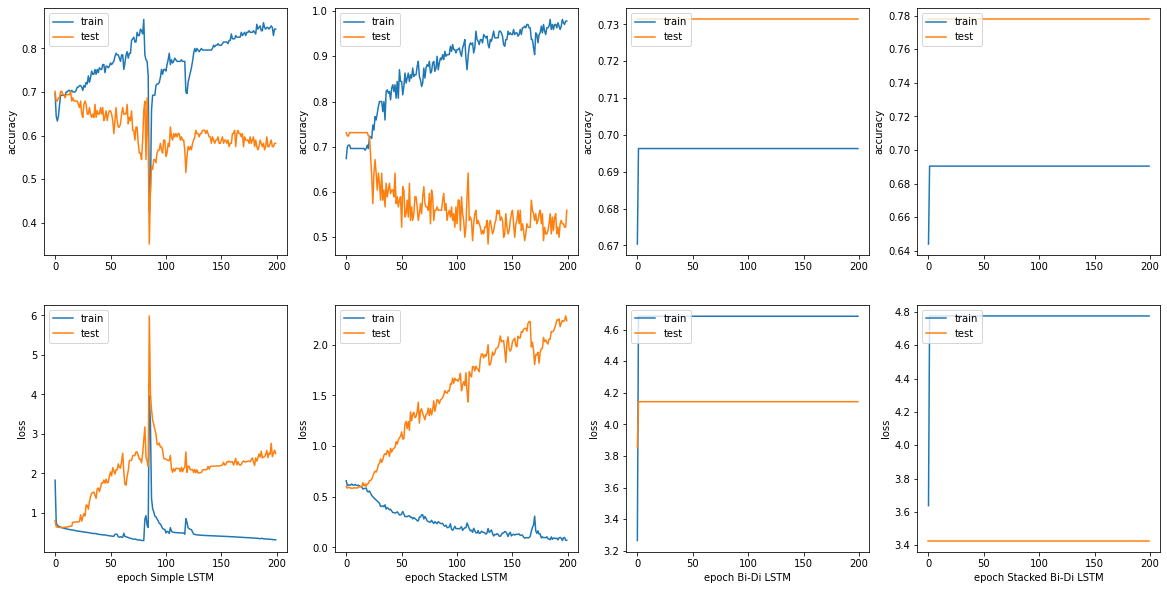

In [51]:
def plot_accuracy_and_loss(model_history, title, pos1, pos2):
    # Plot accuracy vs val_accuracy
    plt.subplot(pos1)
#    plt.suptitle(title)
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.legend(['train', 'test'], loc='upper left')
    # Plot loss vs val_loss
    plt.subplot(pos2)
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch ' + title)
    plt.legend(['train', 'test'], loc='upper left')

plt.figure(figsize=(20,10))

plot_accuracy_and_loss(history_simple, "Simple LSTM", 241, 245)
plot_accuracy_and_loss(history_stacked, "Stacked LSTM", 242, 246)
plot_accuracy_and_loss(history_bidirectional, "Bi-Di LSTM", 243, 247)
plot_accuracy_and_loss(history_stacked_bidirectional, "Stacked Bi-Di LSTM", 244, 248)

# Graph saving
graph_name = "Overall_Performance" + '.png'
plt.savefig(f"{graph_dir}/{graph_name}")

# Save model for prediction

In [52]:
path = "." #path in AWS
model_stacked.save(path  + "/model_stacked:latest")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./model_stacked:latest/assets


In [53]:
#TODO SCALING AND K FOLD CROSS VAL